In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob
from tqdm import tqdm
import io, sys

import pygamma
import gsw

from dask.distributed import Client
import dask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.path as mpath

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45435,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:41557,Total threads: 1
Dashboard: /proxy/43825/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41815,


In [3]:
# 1/10th-degree for product:
#base = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55_ryf_Control/'
#ds = xr.open_mfdataset(glob.glob(base + 'output***/ocean/ocean_month.nc'))

# 1/4-degree for testing:
base = '/g/data/ik11/outputs/access-om2-025/025deg_jra55_ryf9091_gadi/'
ds = xr.open_dataset(base + 'output324/ocean/ocean.nc')
ds_grd = xr.open_dataset(base + 'output234/ocean/ocean_grid.nc')

0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


# Compute Neutral density and save to file

In [4]:
# Define a function to compute for a single longitude:
def compute_gn(lst):
    SA_t = lst[0]
    PT_t = lst[1]
    pressure = lst[2]
    lon = lst[3]
    lat = lst[4]
    try:
        gamma_t, dg_lo, dg_hi = pygamma.gamma_n(SA_t.T, PT_t.T, pressure.T, 0*lat + lon, lat)
    except:
        gamma_t = np.nan*np.ones_like(SA_t.T)
    return(gamma_t)

In [5]:
# Setup calculations (but don't do any computation):
lat_max = 90. # -20.

CT = ds.temp.sel(yt_ocean=slice(-90.,lat_max))-273.15 # Conservative temperature
PS = ds.salt.sel(yt_ocean=slice(-90.,lat_max))        # Practical Salinity

depth = -ds.st_ocean
lon = ds.xt_ocean
lat = ds.yt_ocean.sel(yt_ocean=slice(-90.,lat_max))
pressure = gsw.p_from_z(depth,lat)

SA = xr.zeros_like(CT).copy()                      # Absolute Salinity
PT = xr.zeros_like(CT).copy()                      # Potential Temperature
gamma = xr.zeros_like(CT).copy()                   # Neutral density

In [6]:
# Loop over time and longitude to do computations:

ti = 0
for ti in tqdm(range(len(CT.time))):
    CT_t = CT.isel(time=ti).load()
    PS_t = PS.isel(time=ti).load()

    SA_t = gsw.SA_from_SP(PS_t, pressure, lon, lat)
    PT_t = gsw.t_from_CT(SA_t, CT_t, pressure)

    # Setup dask compute:
    results = []
    for li in range(len(CT_t.xt_ocean)):
        result = dask.delayed(compute_gn)([SA_t.isel(xt_ocean=li),PT_t.isel(xt_ocean=li),pressure,lon.isel(xt_ocean=li),lat])
        results.append(result)

    # Actually do the compute:
    results = dask.compute(*results)

    # Collect the results:
    for li in range(len(CT_t.xt_ocean)):
        gamma[ti,:,:,li] = results[li].T

  0%|          | 0/24 [00:00<?, ?it/s]/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.16 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  4%|▍         | 1/24 [05:17<2:01:45, 317.64s/it]/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.16 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  8%|▊         | 2/24 [10:26<1:54:33, 312.43s/it]/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.16 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 12%|█▎        | 3/24 [15:57<1:52:19, 320.95s/it]/g/data/

In [7]:
# Save to file:
gamma.to_netcdf('/g/data/dx2/rmh561/025deg_jra55_ryf9091_gadi_output324_gamma_n.nc')

### Old ways below this

In [21]:
%%time
li = 1
gamma_t = compute_gn([SA_t.isel(xt_ocean=li),PT_t.isel(xt_ocean=li),pressure,lon.isel(xt_ocean=li),lat])
gamma[ti,:,:,li] = gamma_t.T

CPU times: user 164 ms, sys: 6.66 ms, total: 170 ms
Wall time: 166 ms


In [ ]:
%%time
gamma_t, dg_lo, dg_hi = pygamma.gamma_n(SA_t.stack(z=("xt_ocean","yt_ocean")).T, PT_t.stack(z=("xt_ocean","yt_ocean")).T, (0*lon + pressure).stack(z=("xt_ocean","yt_ocean")).T, (0*lat + lon).stack(z=("xt_ocean","yt_ocean")), (0*lon + lat).stack(z=("xt_ocean","yt_ocean")))

In [7]:
for li in tqdm(range(len(CT_t.xt_ocean))):
    gamma_t, dg_lo, dg_hi = pygamma.gamma_n(SA_t.isel(xt_ocean=0).T, PT_t.isel(xt_ocean=0).T, pressure.T, 0*lat + lon.isel(xt_ocean=0), lat)
    gamma[ti,:,:,li] = gamma_t.T

100%|██████████| 1440/1440 [03:28<00:00,  6.89it/s]


# Make some plots

### Define nice plotting features:

In [4]:
# Load the data:
lat_max = 90.
gamma = xr.open_dataset('/g/data/dx2/rmh561/025deg_jra55_ryf9091_gadi_output324_gamma_n.nc').temp.rename('Gamma_n').sel(yt_ocean=slice(-90.,lat_max)).load()
gamma = gamma.mean('time')

ht = ds_grd.ht.sel(yt_ocean=slice(-90.,lat_max))

In [5]:
# Define function to compute isosurface depth (taken from Dougie, https://forum.access-hive.org.au/t/extracting-isopycnals-from-multi-dimensional-arrays/171/16):
def isosurface(field, target, dim):
    """
    Linearly interpolate a coordinate isosurface where a field
    equals a target

    Parameters
    ----------
    field : xarray DataArray
        The field in which to interpolate the target isosurface
    target : float
        The target isosurface value
    dim : str
        The field dimension to interpolate
        
    Examples
    --------
    Calculate the depth of an isotherm with a value of 5.5:
    
    >>> temp = xr.DataArray(
    ...     range(10,0,-1),
    ...     coords={"depth": range(10)}
    ... )
    >>> isosurface(temp, 5.5, dim="depth")
    <xarray.DataArray ()>
    array(4.5)
    """
    slice0 = {dim: slice(None, -1)}
    slice1 = {dim: slice(1, None)}

    field0 = field.isel(slice0).drop(dim)
    field1 = field.isel(slice1).drop(dim)

    crossing_mask_decr = (field0 > target) & (field1 <= target)
    crossing_mask_incr = (field0 < target) & (field1 >= target)
    crossing_mask = xr.where(
        crossing_mask_decr | crossing_mask_incr, 1, np.nan
    )

    coords0 = crossing_mask * field[dim].isel(slice0).drop(dim)
    coords1 = crossing_mask * field[dim].isel(slice1).drop(dim)
    field0 = crossing_mask * field0
    field1 = crossing_mask * field1

    iso = (
        coords0 + (target - field0) * 
        (coords1 - coords0) / (field1 - field0)
    )

    return iso.max(dim, skipna=True)

In [6]:
# Compute depth of 28.11 isosurface:
dep28p11 = isosurface(gamma, 28.11, 'st_ocean')

/jobfs/113137080.gadi-pbs/ipykernel_390335/3908782174.py:31: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  field0 = field.isel(slice0).drop(dim)
/jobfs/113137080.gadi-pbs/ipykernel_390335/3908782174.py:32: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  field1 = field.isel(slice1).drop(dim)
/jobfs/113137080.gadi-pbs/ipykernel_390335/3908782174.py:40: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  coords0 = crossing_mask * field[dim].isel(slice0).drop(dim)
/jobfs/113137080.gadi-pbs/ipykernel_390335/3908782174.py:41: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  coords1 = crossing_mask * field[dim].isel(slice1).drop(dim)


In [57]:
# Define a classed field that encodes the information:
clas = xr.where(np.isnan(ht),np.nan,0.)
clas = xr.where(np.logical_or(ht-dep28p11 < 0.,np.isnan(dep28p11)),clas,
                xr.where(ht-dep28p11 < 100.,1.,
                        xr.where(ht-dep28p11 < 500.,2.,
                                      xr.where(ht-dep28p11 < 1000.,3.,
                                               xr.where(ht-dep28p11 > 1000., 4.,
                                                        np.nan
                                                  )))))

(-40.0, 60.0)

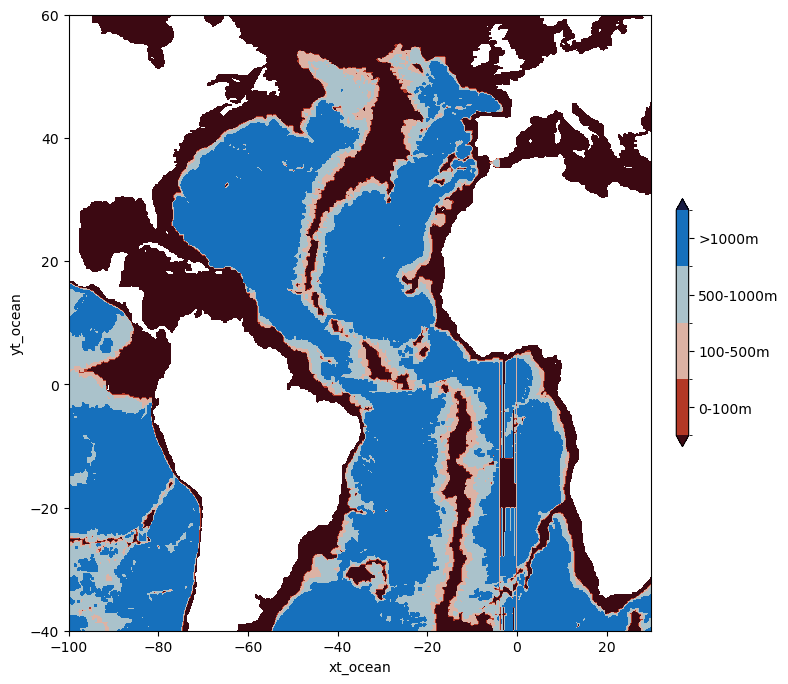

In [67]:
# Atlantic only:
levels = [0.5,1.5,2.5,3.5,4.5] # levels used in contour plots
fig = plt.figure(figsize=(8,8))
cax = clas.plot.contourf(x = 'xt_ocean',y = 'yt_ocean',
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.balance.reversed(),add_colorbar=False)
cbar = fig.colorbar(cax, ticks=[1.,2.,3.,4.],fraction=0.02, pad=0.04)
cbar.ax.set_yticklabels(['0-100m','100-500m','500-1000m','>1000m'])  # vertically oriented colorbar
plt.xlim([-100.,30.])
plt.ylim([-40.,60.])

In [58]:
def circumpolar_map(fig,ax):
    ax.set_extent([-180, 180, -80, 0.], crs=ccrs.PlateCarree())

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='black',
                                                facecolor='papayawhip',
                                                linewidth=0.5),
                   zorder = 2)

    
    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            ylocs = np.arange(-80, 81, 10)
        )

    return

In [ ]:
levels = [0.5,1.5,2.5,3.5,4.5] # levels used in contour plots
fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection = ccrs.SouthPolarStereo())
circumpolar_map(fig,ax)

cax = clas.plot.contourf(ax = ax,
                                   x = 'xt_ocean',
                                   y = 'yt_ocean',
                                   transform = ccrs.PlateCarree(),
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.phase,
                                  add_colorbar=False)
cbar = fig.colorbar(cax, ticks=[1.,2.,3.,4.],fraction=0.02, pad=0.04)
cbar.ax.set_yticklabels(['0-100m','100-500m','500-1000m','>1000m'])  # vertically oriented colorbar

plt.title('Height above bottom of $28.11$kgm$^{-3}$ Neutral Density Surface (ACCESS-OM2-025)')

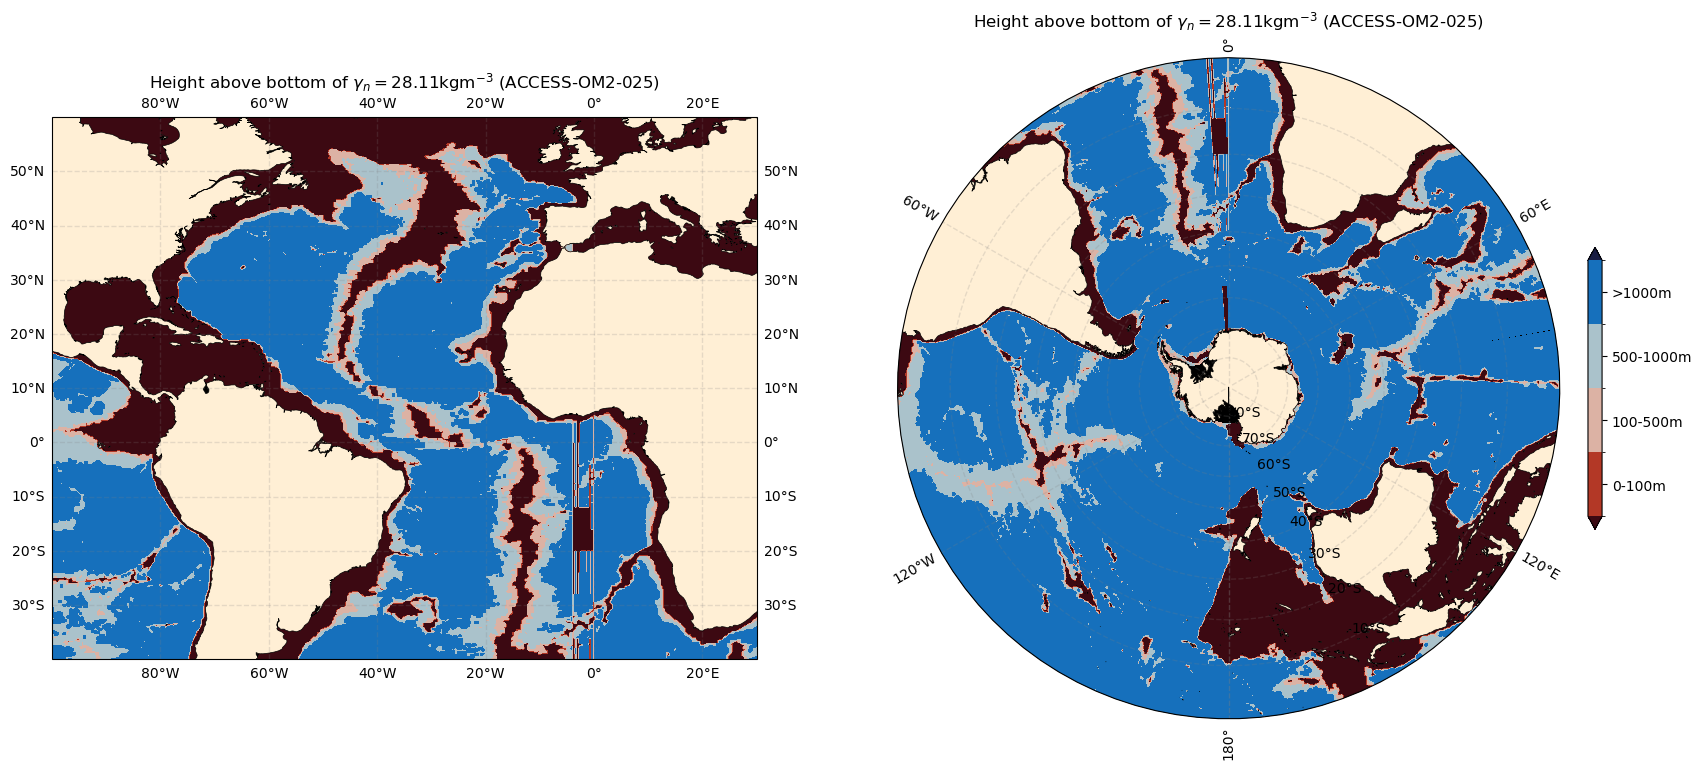

In [68]:
# Atlantic and Southern Ocean:
#fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
fig = plt.figure(figsize=(20,10))
axes = [plt.subplot(121,projection=ccrs.PlateCarree()),
        plt.subplot(122,projection=ccrs.SouthPolarStereo())]

levels = [0.5,1.5,2.5,3.5,4.5] # levels used in contour plots
ticks = [1,2,3,4]
ticklabels = ['0-100m','100-500m','500-1000m','>1000m']

cax = clas.plot.contourf(ax=axes[0],x = 'xt_ocean',y = 'yt_ocean',
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.balance.reversed(),add_colorbar=False)

axes[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='black',
                                                facecolor='papayawhip',
                                                linewidth=0.5),
                   zorder = 2)
gl = axes[0].gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            ylocs = np.arange(-80, 81, 10),
            xlocs = np.arange(-360.,380.,20)
        )

axes[0].set_xlim([-100.,30.])
axes[0].set_ylim([-40.,60.])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Height above bottom of $\gamma_n=28.11$kgm$^{-3}$ (ACCESS-OM2-025)')

circumpolar_map(fig,axes[1])

cax = clas.plot.contourf(ax = axes[1],
                                   x = 'xt_ocean',
                                   y = 'yt_ocean',
                                   transform = ccrs.PlateCarree(),
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.balance.reversed(),
                                   add_colorbar=False)

cbar = fig.colorbar(cax, ticks=ticks,fraction=0.02, pad=0.04)
cbar.ax.set_yticklabels(ticklabels)  # vertically oriented colorbar

for ax in axes:
    ax.set_facecolor('k')
axes[1].set_title('Height above bottom of $\gamma_n=28.11$kgm$^{-3}$ (ACCESS-OM2-025)')
plt.savefig('Atlantic_and_SO_28p11_ACCESS-om2-025.png',dpi=150)

In [ ]:
levels = np.arange(0.,5000.,100.) # levels used in contour plots

fig, ax = circumpolar_map()

(ht-dep28p11).plot.contourf(ax = ax,
                                   x = 'xt_ocean',
                                   y = 'yt_ocean',
                                   transform = ccrs.PlateCarree(),
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.amp)
(ht-dep28p11).plot.contour(ax = ax,
                                   x = 'xt_ocean',
                                   y = 'yt_ocean',
                                   transform = ccrs.PlateCarree(),
                                   levels = [100.],colors='k')
(ht-dep28p11).plot.contour(ax = ax,
                                   x = 'xt_ocean',
                                   y = 'yt_ocean',
                                   transform = ccrs.PlateCarree(),
                                   levels = [500.],colors='b')
plt.title('Height above bottom of $28.11$kgm$^{-3}$ Neutral Density Surface (ACCESS-OM2-025)')